Library import

In [3]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras import callbacks
from keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout, Input
from keras import Model
from keras.layers import  Conv2D, MaxPool2D, add
from keras.preprocessing import image
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

Creation of data generators for train, valid and test based on the dataset

In [4]:
training_path = '../datasets/cats_and_dogs/training_set/training_set/'
test_path = '../datasets/cats_and_dogs/test_set/test_set/'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 150

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='training'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='validation'
)

Found 8005 files belonging to 2 classes.
Using 6805 files for training.
Found 2023 files belonging to 2 classes.
Found 8005 files belonging to 2 classes.
Using 1200 files for validation.


In [6]:
# in order to access the generator elements, you can use the .take() method. For example:
# for batch, labels in train_ds.take(1):
#     print(batch, labels)

EDA

In [7]:
cnt_imgs = 16  # we take 8 images for each class
cat_path = training_path + '/cats'
dog_path = training_path + '/dogs'
cat_imgs = os.listdir(cat_path)[:cnt_imgs]
dog_imgs = os.listdir(dog_path)[:cnt_imgs]

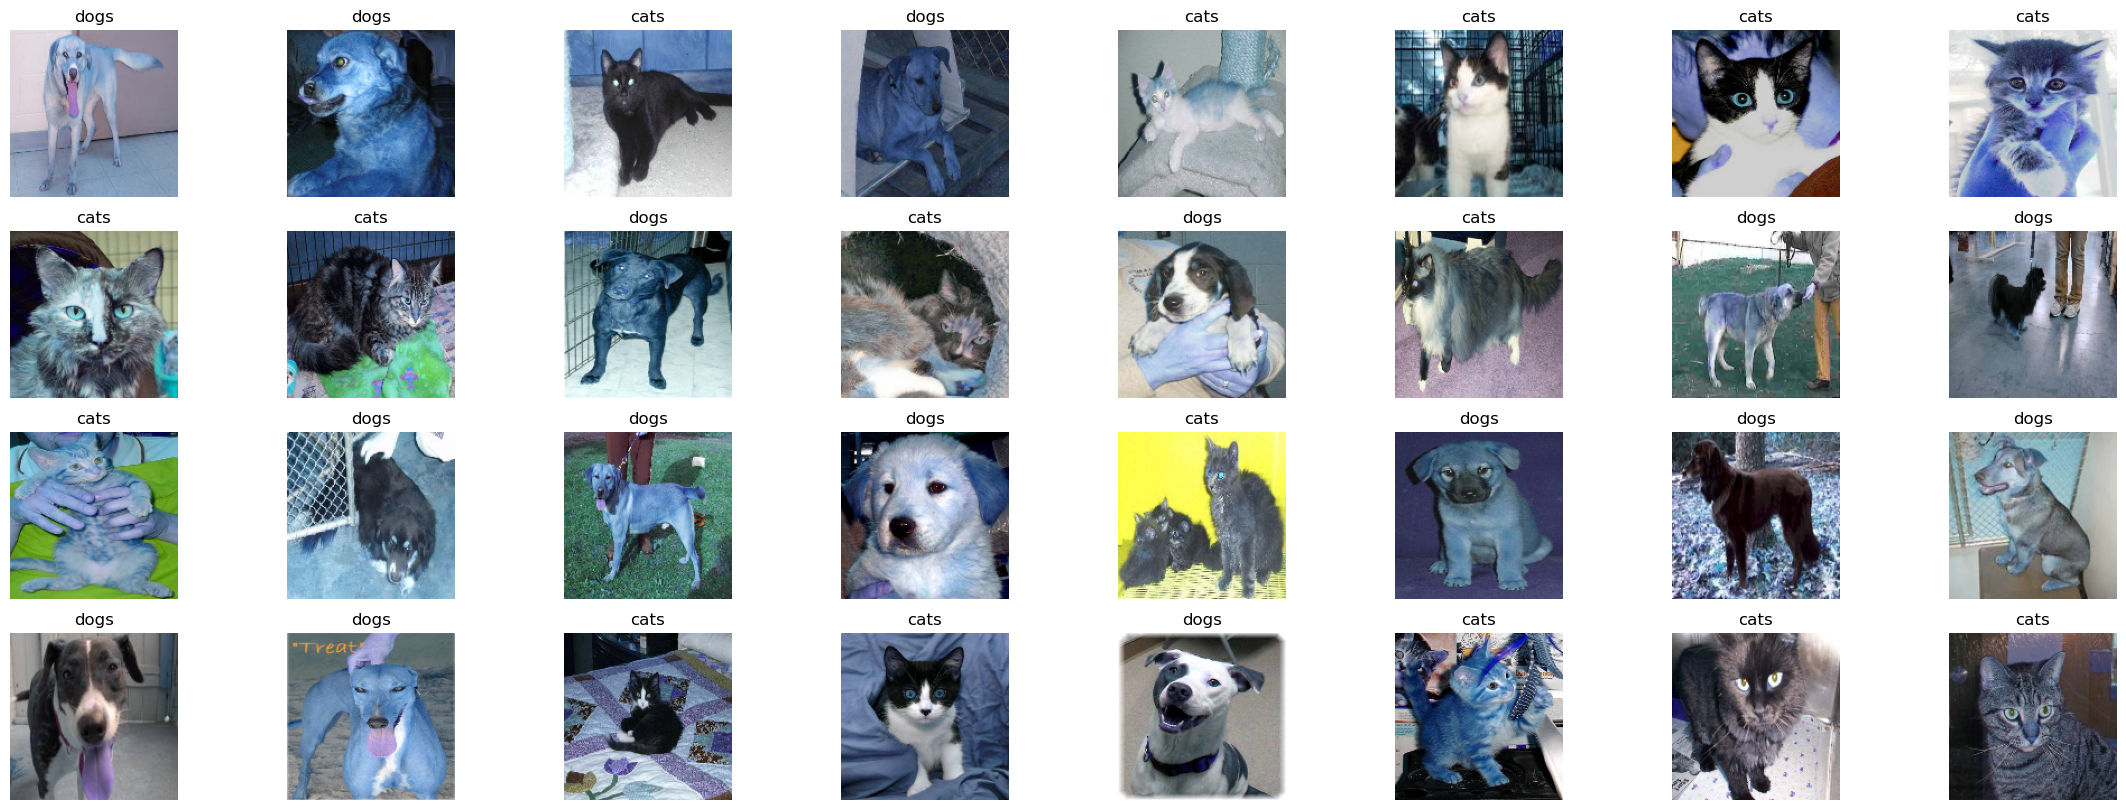

In [8]:
counter = 0
cat_imgs_path = [cat_path + '/' + i for i in cat_imgs]
dog_imgs_path = [dog_path + '/' + j for j in dog_imgs]
all_imgs = cat_imgs_path + dog_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(training_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

Check if there is an imbalance of classes:

In [9]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [training_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_CAT = check_cnt_label('cats')
CNT_DOG = check_cnt_label('dogs')

In [10]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Cats', 'Dogs'],
    y=[CNT_CAT, CNT_DOG],
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

Data preprocessing

In [11]:
rescale = Rescaling(scale=1.0/255)
train_ds = train_ds.map(lambda image, label: (rescale(image), label))
valid_ds = valid_ds.map(lambda image, label: (rescale(image), label))
test_ds = test_ds.map(lambda image, label: (rescale(image), label))

Creation of a CNN model

In [12]:
EPOCHS = 35

In [13]:
CALLBACKS = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=7, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')
]

In [14]:
inputs = Input(shape=(IMAGE_SIZE + (3,)))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
output = Dense(1, activation='sigmoid')(x)

In [15]:
model = Model(inputs, output)

In [16]:
model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')

In [17]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=CALLBACKS)

Epoch 1/35
46/46 [==============================] - 308s 6s/step - loss: 0.7059 - Accuracy: 0.5809 - val_loss: 0.7685 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 2/35
46/46 [==============================] - 281s 6s/step - loss: 0.6518 - Accuracy: 0.5999 - val_loss: 0.7452 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 3/35
46/46 [==============================] - 265s 6s/step - loss: 0.6309 - Accuracy: 0.6332 - val_loss: 0.7350 - val_Accuracy: 0.4917 - lr: 0.0010
Epoch 4/35
46/46 [==============================] - 315s 7s/step - loss: 0.6136 - Accuracy: 0.6514 - val_loss: 0.7220 - val_Accuracy: 0.5100 - lr: 0.0010
Epoch 5/35
46/46 [==============================] - 265s 6s/step - loss: 0.5813 - Accuracy: 0.6866 - val_loss: 0.7235 - val_Accuracy: 0.5175 - lr: 0.0010
Epoch 6/35
46/46 [==============================] - 264s 6s/step - loss: 0.5602 - Accuracy: 0.7080 - val_loss: 0.7100 - val_Accuracy: 0.5250 - lr: 0.0010
Epoch 7/35
46/46 [==============================] - 270s 6s/step - loss: 0.5

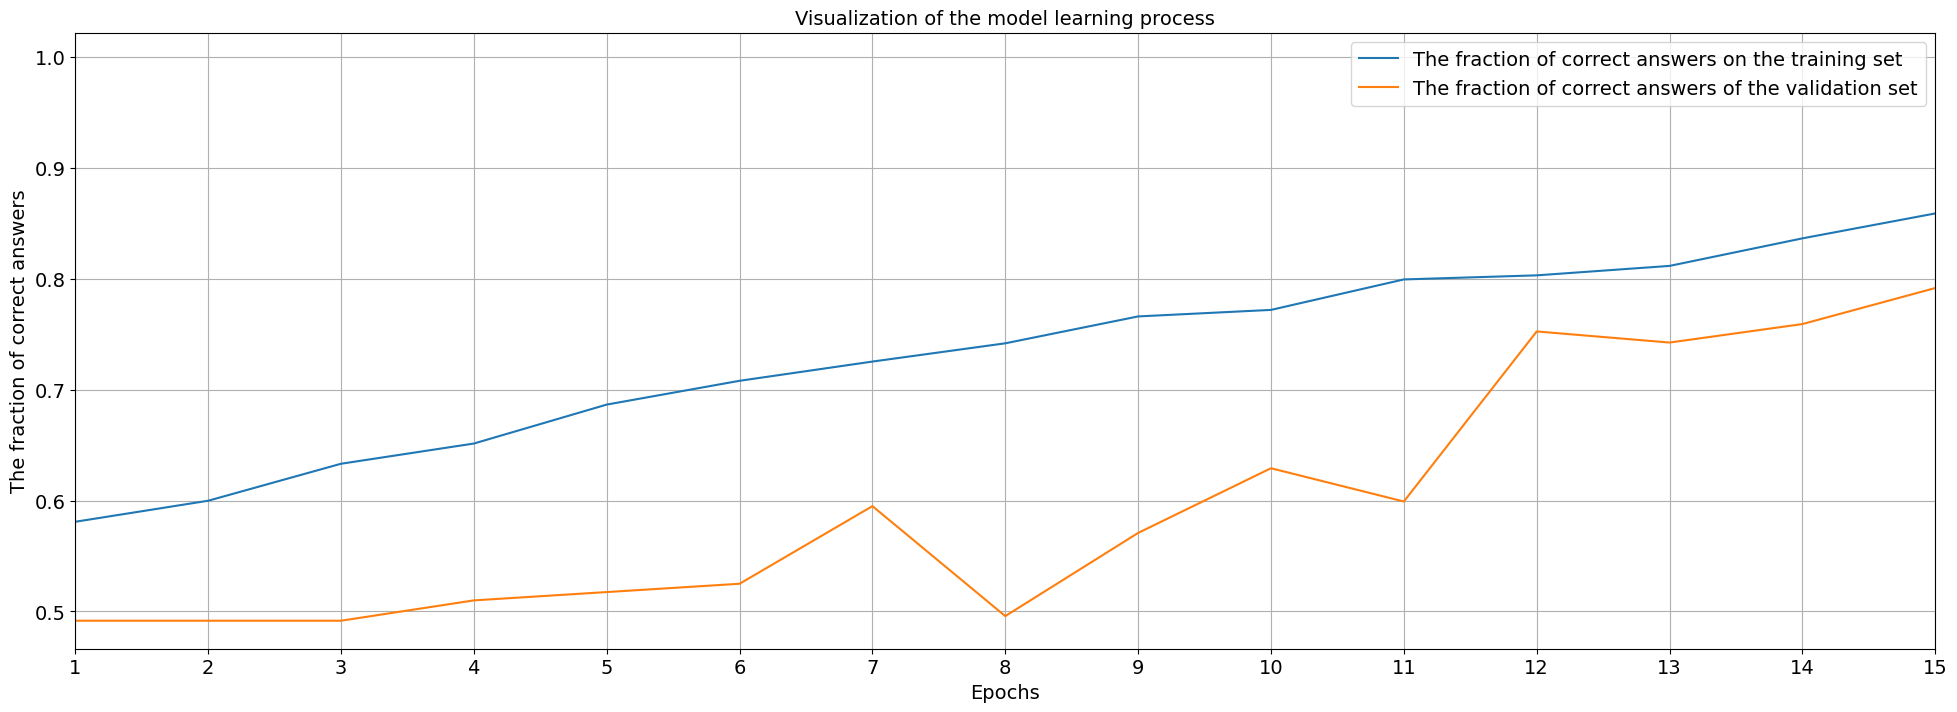

In [18]:
plt.figure(figsize=(24, 8))
plt.title('Visualization of the model learning process', fontsize=14)
plt.plot(np.arange(1, EPOCHS + 1), history.history['Accuracy'], label='The fraction of correct answers on the training set') 
plt.plot(np.arange(1, EPOCHS + 1), history.history['val_Accuracy'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(np.arange(1, EPOCHS + 1), fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, 15)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 148, 148, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 148, 148, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
test_result = model.evaluate(test_ds, verbose=0)[1]
train_result = model.evaluate(train_ds, verbose=0)[1]
print(f'Metric on test: {test_result}')
print(f'Metric on train: {train_result}')

Metric on test: 0.9144834280014038
Metric on train: 0.9976487755775452


In [22]:
predictions = model.predict(test_ds)

14/14 [==============================] - 12s 794ms/step


In [21]:
model.save('dog_cat_classifier.h5')

In [23]:
new_model = keras.models.load_model('dog_cat_classifier.h5')

In [25]:
test_result = new_model.evaluate(test_ds, verbose=0)[1]
train_result = new_model.evaluate(train_ds, verbose=0)[1]
print(f'Metric on test: {test_result}')
print(f'Metric on train: {train_result}')

Metric on test: 0.9144834280014038
Metric on train: 0.9976487755775452


In [27]:
new_predictions = new_model.predict(test_ds)

14/14 [==============================] - 13s 849ms/step
